In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=0d082275199321030f85ad035adfab0a04dd39900257fc84d75a2af64f514b28
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()
print('Spark Version: {}'.format(spark.version))

Spark Version: 3.5.0


In [ ]:
#Loading the data
dataset = spark.read.csv("seeds_dataset.csv",header=True,inferSchema=True)
#show the data in the above file using the below command
dataset.show(5)

+-----+---------+-----------+----------------+---------------+---------------------+----------------------+
| Area|Perimeter|Compactness|Length_of_kernel|Width_of_kernel|Asymmetry_coefficient|Length_of_kernel_grove|
+-----+---------+-----------+----------------+---------------+---------------------+----------------------+
|15.26|    14.84|      0.871|           5.763|          3.312|                2.221|                  5.22|
|14.88|    14.57|     0.8811|           5.554|          3.333|                1.018|                 4.956|
|14.29|    14.09|      0.905|           5.291|          3.337|                2.699|                 4.825|
|13.84|    13.94|     0.8955|           5.324|          3.379|                2.259|                 4.805|
|16.14|    14.99|     0.9034|           5.658|          3.562|                1.355|                 5.175|
+-----+---------+-----------+----------------+---------------+---------------------+----------------------+
only showing top 5 rows



In [ ]:
#Print schema
dataset.printSchema()

root
 |-- Area: double (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- Length_of_kernel: double (nullable = true)
 |-- Width_of_kernel: double (nullable = true)
 |-- Asymmetry_coefficient: double (nullable = true)
 |-- Length_of_kernel_grove: double (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler
vec_assembler = VectorAssembler(inputCols = dataset.columns, outputCol='features')
final_data = vec_assembler.transform(dataset)
final_data.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[15.26,14.84,0.87...|
|[14.88,14.57,0.88...|
|[14.29,14.09,0.90...|
|[13.84,13.94,0.89...|
|[16.14,14.99,0.90...|
+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features",  outputCol="scaledFeatures",  withStd=True,  withMean=False)
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)
final_data.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[5.24452795332028...|
|[5.11393027165175...|
|[4.91116018695588...|
|[4.75650503761158...|
|[5.54696468981581...|
+--------------------+
only showing top 5 rows



In [ ]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    model=kmeans.fit(final_data)
    predictions=model.transform(final_data)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.6613125038335929
Silhouette Score for k = 3 is 0.5959078263451633
Silhouette Score for k = 4 is 0.4943210687863144
Silhouette Score for k = 5 is 0.4166976682907412
Silhouette Score for k = 6 is 0.3648649810130078
Silhouette Score for k = 7 is 0.39397743262544
Silhouette Score for k = 8 is 0.40573744412356627
Silhouette Score for k = 9 is 0.3877256432563701


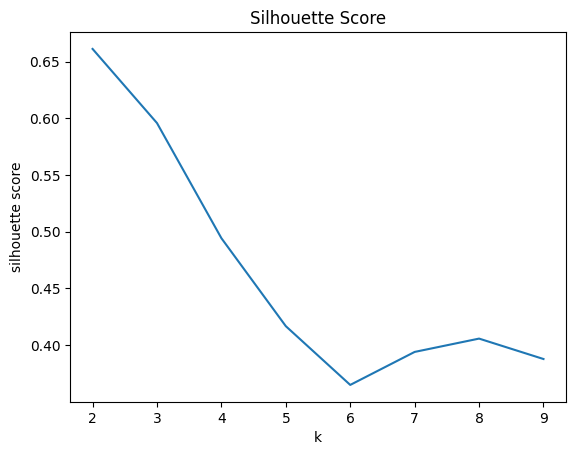

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [ ]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

In [ ]:
# Printing cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 4.91589737 10.9321157  37.2641905  12.39722305  8.58688868  1.77370551
 10.37323607]
[ 6.3407095  12.39263108 37.41143125 13.92892299  9.77251635  2.42396744
 12.28547936]
[ 4.06818854 10.13938448 35.87110297 11.81191124  7.52564313  3.24586152
 10.40780927]


In [ ]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 5 rows



In [ ]:
#End Session
spark.stop()